In [1]:
# %pip install tf_keras_vis tflite-support-nightly

# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
# Load training and test datasets (generated columns are: [path, label])
train_df = create_dataframe_from_directories("thumbnail_dl/thumbnails")
test_df = create_dataframe_from_directories("thumbnail_dl/test")

In [4]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['Linus_Tech_Tips', 'Underscore', 'Computerphile'], dtype=object)

**TODO**: Display some images of your dataset

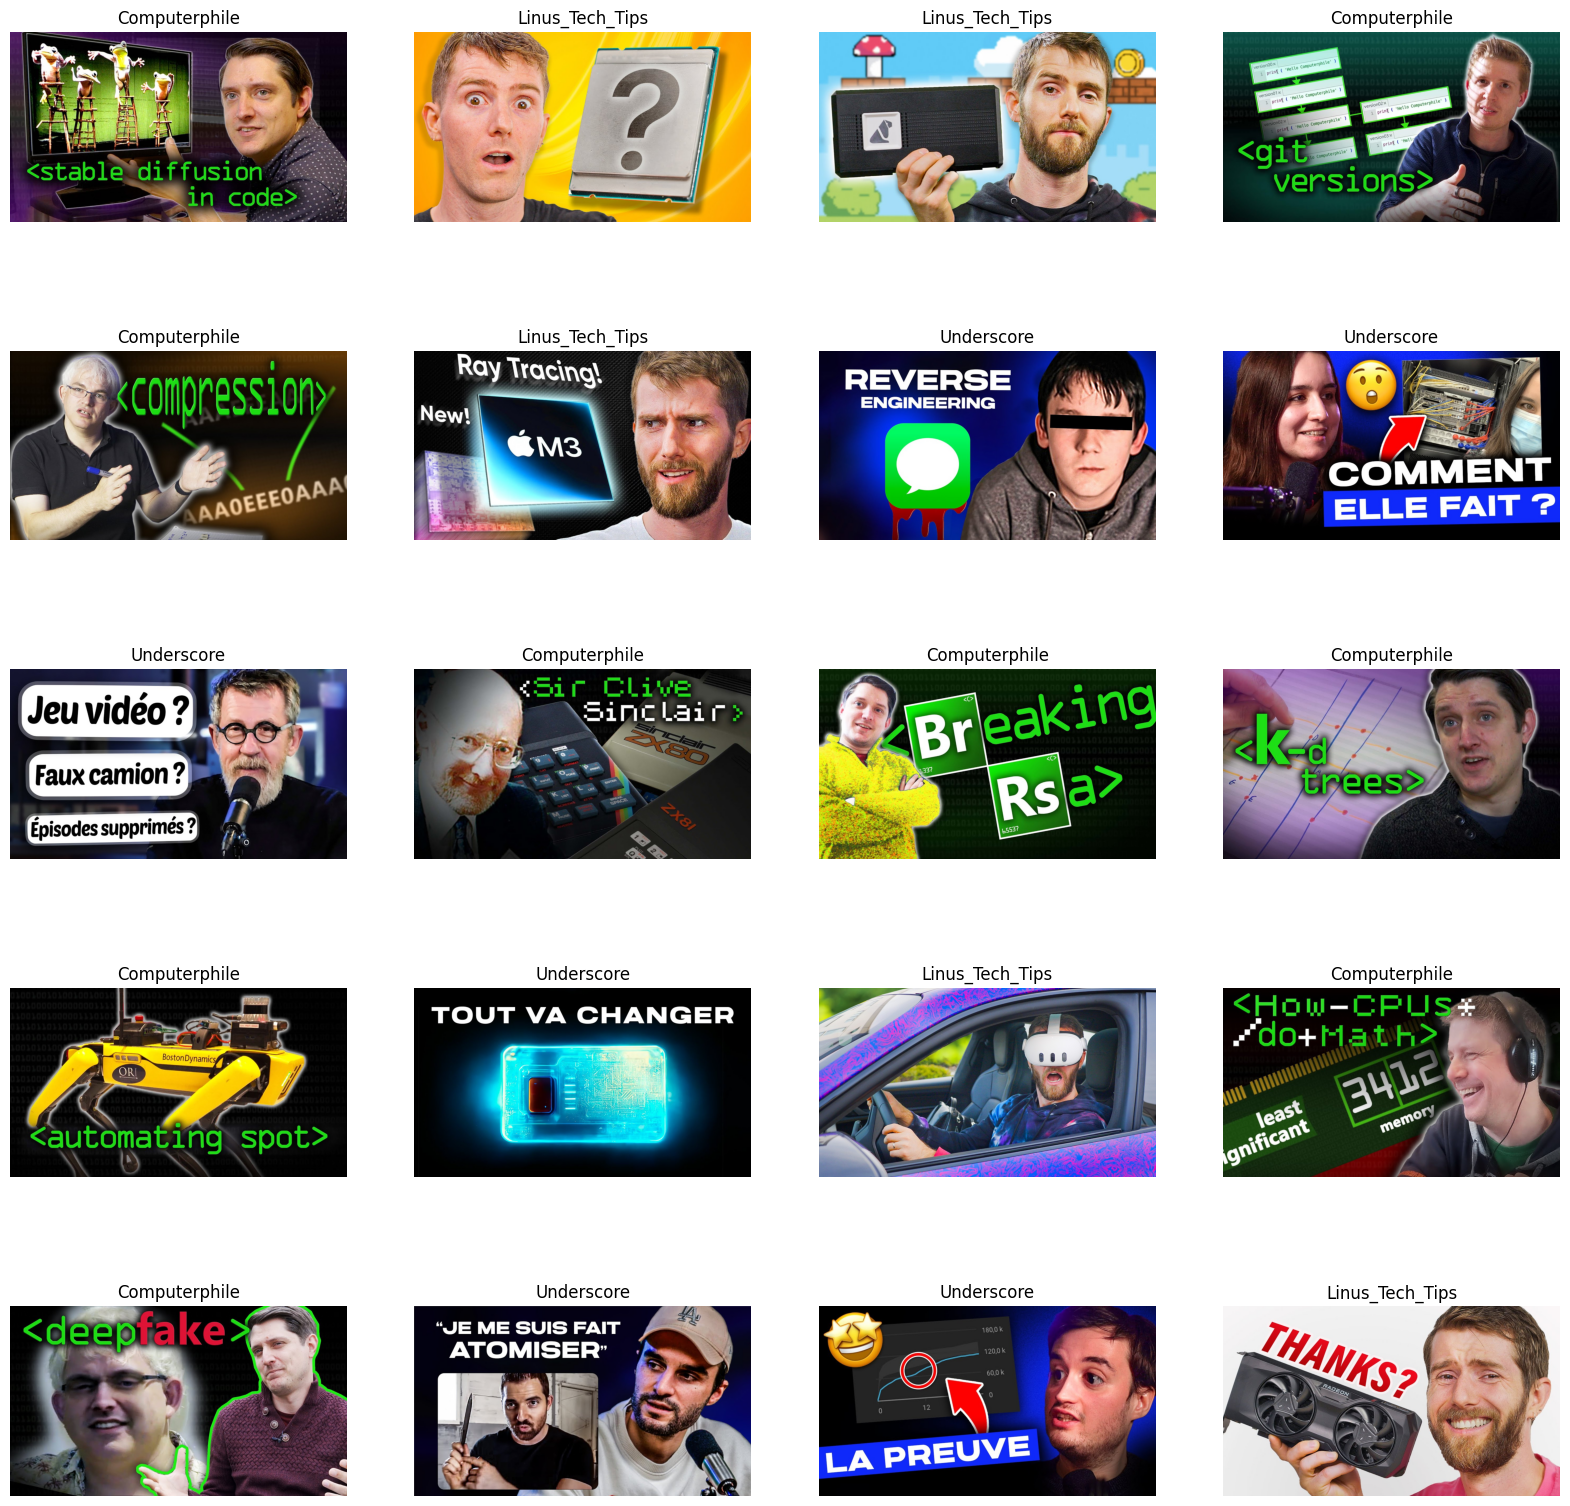

In [5]:
# From notebook 1
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(20).iterrows():
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

# Preprocessing steps

In [6]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomRotation
)

from tensorflow.keras import Sequential

# Sizes used in MobileNetV2
IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    # We resize with the crop mode (probably a square in the middle)
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True), # TODO: maybe switch to pad_to_aspect_ratio
    Rescaling(1. / 255) # normalize values between 0 and 1
])

# https://www.tensorflow.org/tutorials/images/data_augmentation
image_augmentations = Sequential([
    # A little bit of rotation (45degrees, fill holes with 0)
    RandomRotation(factor=1/8, fill_mode='constant'),
    # A little bit of zoom out (2 times back)
    Resizing(
        height=IMG_HEIGHT *2,
        width=IMG_WIDTH *2,
        pad_to_aspect_ratio=True,
    )
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

2024-05-31 15:42:35.695709: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 15:42:35.696786: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 15:42:35.900473: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 15:42:36.417860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:42:38.774651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

**TODO**: plot examples of preprocessed and augmented images

## Define model

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    Conv2D,
    Flatten,
    MaxPooling2D,
    Input
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(),
        # Conv2D(10, (10,10), padding='same', activation='relu', name='l1'),
        # MaxPooling2D(pool_size=(2,2), name='l1_mp'),
        # Dropout(0.3),
        # Conv2D(10, (10,10), padding='same', activation='relu', name='l2'),
        # MaxPooling2D(pool_size=(2,2), name='l2_mp'),
        # Dropout(0.3),
        # Flatten()
        Dense(100, activation='relu'),
        # Dropout(0.3),
        Dense(3, activation='softmax')

    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False
    # TODO: maybe try to freeze less layers later

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [8]:
get_model().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,386,387 (9.10 MB)

 Trainable params: 128,403 (501.57 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 761ms/step - acc: 0.4363 - loss: 1.8219 - val_acc: 0.8000 - val_loss: 0.5634
Epoch 2/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 626ms/step - acc: 0.8195 - loss: 0.5143 - val_acc: 0.7789 - val_loss: 0.5145
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 617ms/step - acc: 0.8143 - loss: 0.4980 - val_acc: 0.7789 - val_loss: 0.5273
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 626ms/step - acc: 0.9047 - loss: 0.2780 - val_acc: 0.9158 - val_loss: 0.2544
Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 764ms/step - acc: 0.4776 - loss: 2.1791 - val_acc: 0.7895 - val_loss: 0.6262
Epoch 2/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 618ms/step - acc: 0.7867 - loss: 0.5536 - val_acc: 0.7263 - val_loss: 0.5823
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 607ms/step - acc: 0.9037 - loss: 0.3053 - val_acc: 0.9053 - val_loss: 0.3555
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - acc: 0.9152 - loss: 0.2435 - val_acc: 0.7895 - val_loss: 0.4591
Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 742ms/step - acc: 0.4

# Results

**TODO**: plot the results from your crossvalidation

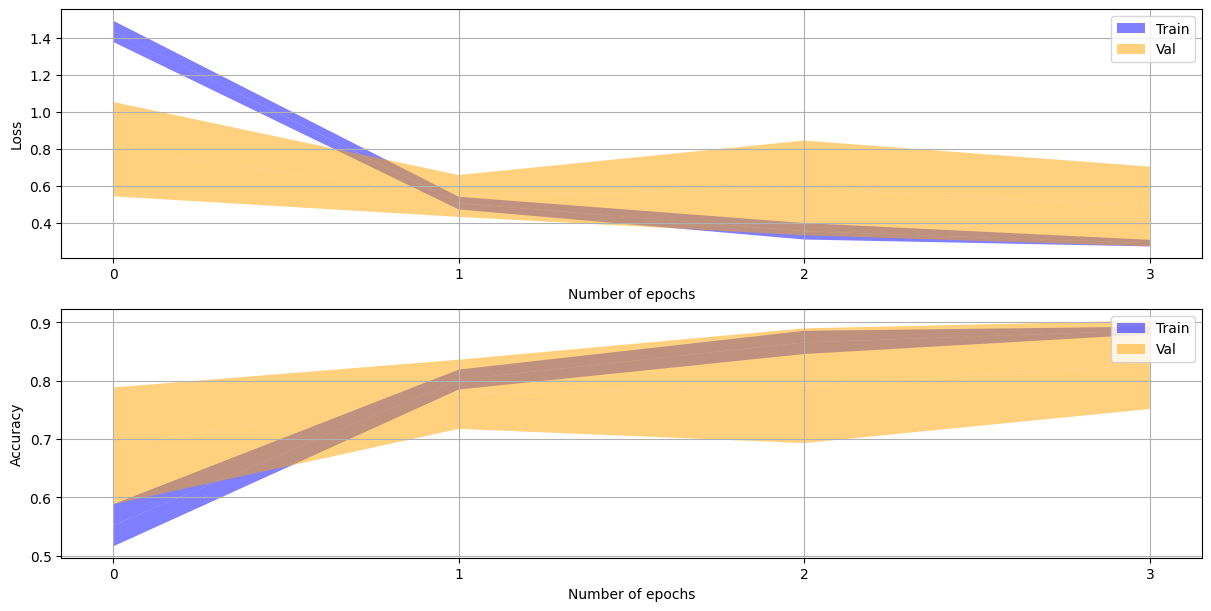

In [12]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

ModuleNotFoundError: No module named 'tf_keras_vis'

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it